In [7]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [8]:
df = pd.read_excel('Resumes (For Applicants).xlsx')

Some rows have these two columns swapped.
Looking at the Excel file, rows that have been swapped are those where **Reason_for_decision** starts with "expected_experience".
As such, we check for rows that start like that, and swap them with the **Job_Description** column.

In [9]:
swapped_indices = []

for idx, row in df.iterrows():
    reason_col = str(row['Reason_for_decision']).strip().lower()
    if reason_col.startswith('expected_experience'):
        swapped_indices.append(idx)

if len(swapped_indices) > 0:
    for idx in swapped_indices:
        df.loc[idx, 'Reason_for_decision'], df.loc[idx, 'Job_Description'] = df.loc[idx, 'Job_Description'], df.loc[idx, 'Reason_for_decision']

Convert all data to lowercase as part of preprocessing of data.

In [10]:
text_columns = df.select_dtypes(include=['object', 'string']).columns

for col in text_columns:
    df[col] = df[col].str.lower()

In [11]:
def get_email(text):
    """Gets email in Resume column using regex."""
    email = re.findall(r'\S+@\S+', str(text))
    return email[0] if email else "Not Found"

def get_phone(text):
    """Gets phone number following American format: 123-456-7890 or (123) 456-7890"""
    phone = re.findall(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4})', str(text))
    return phone[0] if phone else "Not Found"

def get_name(text):
    """Gets name from resume column.

    Names appear in specific patterns at the start of resumes:
        1. **candidate profile: Name** or **data scientist candidate profile: Name**
        2. Here's a sample/professional resume for Name
        3. **Name** (just name in bold)
        4. Plain name on first line
    """
    
    lines = str(text).split('\n')
    
    for line in lines:
        line_stripped = line.strip()
        if not line_stripped:
            continue
            
        # Pattern 1: **candidate profile: Name** or **data scientist candidate profile: Name**
        match = re.search(r'\*\*.*?candidate profile:\s*(.+?)\*\*', line_stripped, re.IGNORECASE)
        if match:
            return match.group(1).strip()
        
        # Pattern 2: Here's a sample/professional resume for Name
        match = re.search(r"here'?s?\s+a\s+(sample|professional)\s+resume\s+for\s+(.+)", line_stripped, re.IGNORECASE)
        if match:
            return match.group(2).strip()
        
        # Pattern 3: **Name** (just name in bold, no other text)
        match = re.search(r'^\*\*(.+?)\*\*$', line_stripped)
        if match:
            name = match.group(1).strip()
            # Make sure it's not a profile pattern
            if 'candidate profile' not in name.lower():
                return name
        
        # Pattern 4: Plain name (first non-empty line that doesn't match above)
        # Limit line to less than 50 characters because names are not long.
        if len(line_stripped) < 50 and not line_stripped.endswith('.'):
            return line_stripped
    
    # If no text found, return "Not Found"
    return "Not Found"

def get_education(text):
    """
    Extract education information based on the structured format:
    - Looks for "education:" or "**education:**" line (lowercase since preprocessing lowercases all text)
    - Gets the next non-empty line which contains the degree
    - Format: * bachelor of science in computer science, xyz university (2010-2014)
    - Returns only the degree part (before the comma), without university name
    Note: All text is already lowercased during preprocessing
    """
    lines = str(text).split('\n')
    found_education_header = False
    
    for i, line in enumerate(lines):
        line_stripped = line.strip()
        
        # Look for Education header (education: or **education:**) - all lowercase since preprocessing
        if not found_education_header:
            # Check if this line is the Education header (case-insensitive for safety)
            if re.match(r'^\*{0,2}education:\*{0,2}$', line_stripped, re.IGNORECASE):
                found_education_header = True
                continue
        else:
            # We found the Education header, now look for the next non-empty line
            if line_stripped:
                # Clean the line: remove leading asterisks and bold markers
                cleaned = re.sub(r'^\*+\s*', '', line_stripped)  # Remove leading asterisks
                cleaned = re.sub(r'^\*\*(.+?)\*\*', r'\1', cleaned)  # Remove bold markers
                
                # Extract degree (everything before the comma, which separates from university)
                # Format: bachelor of science in computer science, xyz university (2010-2014)
                # We want: bachelor of science in computer science
                if ',' in cleaned:
                    degree = cleaned.split(',')[0].strip()
                    return degree
                else:
                    # If no comma, return the whole line (some might not have university)
                    return cleaned
    
    # If no education found, return "Not Found"
    return "Not Found"

# This function extracts work experience (in years if mentioned)
def get_experience(text):
    # Pattern to find "X years" or "X+ years" or "X-Y years"
    # Example: "5 years of experience" or "3+ years in Python"
    exp = re.findall(r'(\d+)\+?\s*(?:-\s*\d+)?\s*years?', str(text).lower())
    if exp:
        # Convert the found number to integer and return it
        # If multiple years mentioned, take the first one
        return int(exp[0])
    else:
        # If no years mentioned, return 0
        return 0

# This function finds skills mentioned in the resume
def get_skills(text):
    # Define a comprehensive list of technical skills to look for
    # These are common skills in tech jobs
    keywords = [
        'python', 'java', 'javascript', 'sql', 'r', 'c++', 'c#',
        'machine learning', 'deep learning', 'data analysis', 'statistics',
        'tableau', 'power bi', 'excel', 'aws', 'azure', 'cloud',
        'git', 'docker', 'kubernetes', 'tensorflow', 'pytorch',
        'html', 'css', 'react', 'angular', 'node.js', 'flask', 'django'
    ]
    # Convert resume text to lowercase for easier matching
    text_lower = str(text).lower()
    # Check each skill keyword and keep the ones found in the resume
    # Use regex word boundaries (\b) to match whole words only, preventing 'r' from matching 'ready'
    found = [word for word in keywords if re.search(r'\b' + re.escape(word) + r'\b', text_lower)]
    # Join all found skills with commas, or return "None" if no skills found
    return ", ".join(found) if found else "None"

# %% [4] Apply Extraction to All Resumes
# Now we apply each extraction function to every resume in our dataset
# This creates new columns in our table (dataframe) with the extracted info

# Extract email from each resume and create a new 'Email' column
df['Email'] = df['Resume'].apply(get_email)

# Extract phone number from each resume and create a new 'Phone' column
df['Phone'] = df['Resume'].apply(get_phone)

# Extract name from each resume and create a new 'Name' column
df['Name'] = df['Resume'].apply(get_name)

# Extract education from each resume and create a new 'Education' column
df['Education'] = df['Resume'].apply(get_education)

# Extract years of experience from each resume
df['Experience_Years'] = df['Resume'].apply(get_experience)

# Extract skills from each resume and create a new 'Skills' column
df['Skills'] = df['Resume'].apply(get_skills)

## TASK 2

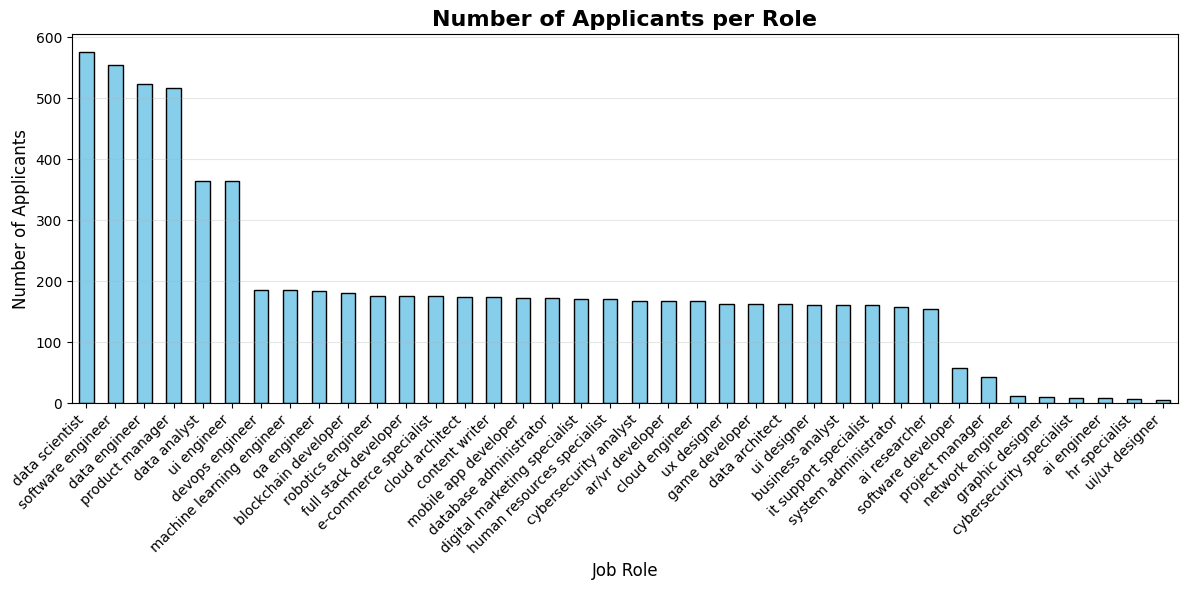

In [12]:
# Which jobs are most frequently applied for?
plt.figure(figsize=(12,6))

# Count how many applicants applied for each role and create a bar chart
# value_counts() counts occurrences of each unique role
# plot(kind='bar') makes a bar chart
df['Role'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

# Add a title to explain what this chart shows
plt.title("Number of Applicants per Role", fontsize=16, fontweight='bold')

# Label the x-axis (horizontal) and y-axis (vertical)
plt.xlabel("Job Role", fontsize=12)
plt.ylabel("Number of Applicants", fontsize=12)

# Rotate the x-axis labels by 45 degrees so they don't overlap
plt.xticks(rotation=45, ha='right')

# Add a grid in the background to make values easier to read
plt.grid(axis='y', alpha=0.3)

# tight_layout() ensures nothing gets cut off
plt.tight_layout()

# Display the chart
plt.show()